### Анализ результатов A/B-тестирования: кумулятивные метрики

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
ab_data = pd.read_csv('data/ab_data.csv')
ab_data

user_id	идентификатор пользователя, зашедшего на сайт
timestamp	дата события
group	группа теста (контрольная или тестовая)
converted	совершил пользователь целевое действие (нажатие кнопки «добавить в корзину» на сопутствующем товаре) или нет. 1 — да, 0 — нет.

In [5]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


#### перевести столбец с информацией о дате события (timestamp) в формат datetime.

In [6]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

#### Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода reset_index() и переименуем столбец user_id в users_count с помощью метода rename().

In [7]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


##### Рассчитайте конверсию на каждый день по приведённой формуле. Результат занесите в столбец conversion. 

In [11]:
daily_data['conversion'] = daily_data['converted'] / daily_data['users_count'] *100

print(round(daily_data[
    (daily_data['timestamp'] == '2017-01-05') & (daily_data['group'] == 'A')
]['conversion'], 2))
display(daily_data.head())

6    12.32
Name: conversion, dtype: float64


,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


### ВИЗУАЛЬНЫЙ АНАЛИЗ КОНВЕРСИИ В ГРУППАХ

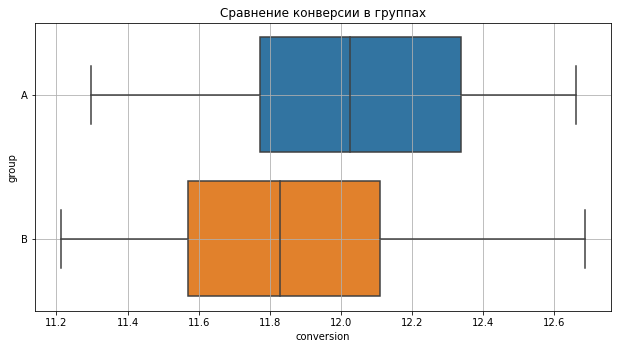

In [12]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid();

##### Давайте вычислим средний и медианный показатель конверсии в контрольной и тестовой группе и умножим результат на 100 (получим результат в процентах):

Примечание. Прежде чем делать выводы по визуальному представлению данных, всегда обращайте внимание на численные значения показателей. Они могут различаться в масштабе графика, но на практике разница между ними не будет иметь значения. Также всегда стоит убедиться, что в данных нет выбросов (базовый вариант — сравнить медиану и среднее между собой). Далее мы ещё поговорим о стабилизации показателя во времени.

In [13]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Возникает вопрос: а значима ли вообще такая разница в показателях или она обусловлена случайностью, и варианты A и B одинаково эффективны по метрике конверсии?

Прежде чем отвечать на этот вопрос, нам нужен ответ на другой вопрос: а стабилен ли показатель конверсии в группах во времени или он колеблется как «уж на сковородке»? 

Примечание. Вопрос о стабильности метрик является обязательным. Прогонять результаты через статистические тесты можно только после того, как вы убедитесь, что разница в ваших показателях стабилизировалась во времени. Это связано с проблемой подглядывания, речь о которой пойдёт ниже.

### КУМУЛЯТИВНЫЕ МЕТРИКИ

Кумулятивная метрика — это отображение целевой метрики, когда вы отслеживаете её поведение за каждый день — накопленным итогом по дням. 

##### Важно! Принимать какие-либо решения стоит только после того, как метрика стабилизируется!

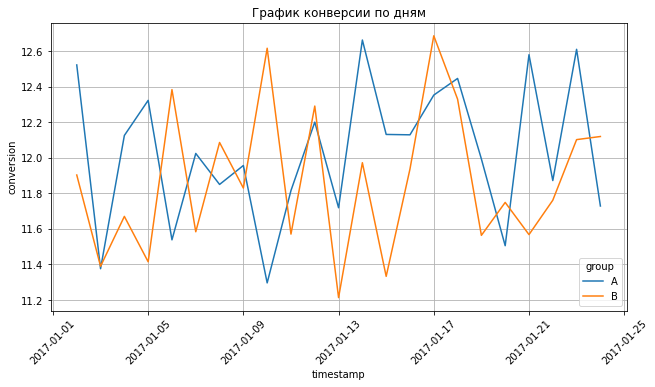

In [14]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid();

Что можно сказать по такому графику? Да практически ничего! Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше, — практически невыполнимая задача. 

Именно поэтому и принято смотреть график кумулятивной конверсии, где за каждый день отображаются данные накопленным итогом.

Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count, в который запишем результат работы метода cumsum() по столбцу users_count:

In [15]:
# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head())

C:\Users\LocalAdmin\AppData\Local\Temp\ipykernel_6216\906787284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


После этого рассчитаем кумулятивную конверсию — это отношение ежедневной кумулятивной суммы количества посетителей к ежедневной кумулятивной сумме количества совершённых целевых действий:

In [16]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


А теперь построим графики кумулятивной конверсии по дням в каждой группе:

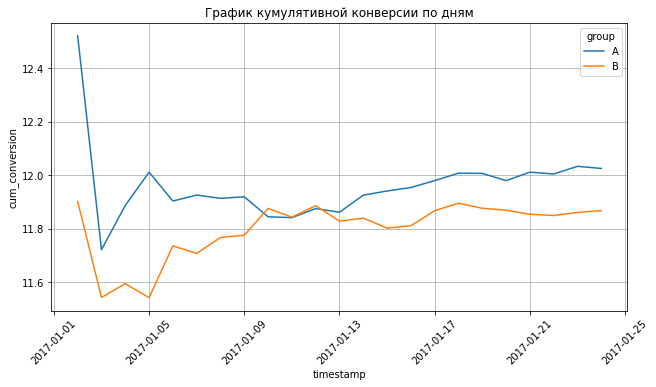

In [17]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Что можно сказать теперь? До 2017-01-09 конверсия была нестабильна, но после 2017-11-01 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. 

#### ВВОДНЫЕ ДАННЫЕ ДЛЯ ЗАДАЧ 4.6–4.9

In [18]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')

Каждая таблица имеет следующие поля:

date — дата наблюдения;
cid — идентификатор посетителя;
transactions — количество совершённых целевых действий (транзакций);
revenue — сумма покупки;
group — группа (тестовая — А, контрольная — B).
Используйте эти данные для ответа на следующие вопросы.

Постройте таблицу со следующими ежедневными показателями:

количество посетителей сайта;

суммарное число транзакций;

общая сумма покупок (выручка).

Для этого сгруппируйте данные по признаку date, предварительно преобразовав его к типу datetime.

In [20]:
sample_a['date'] = pd.to_datetime(sample_a['date'], format='%Y-%m-%d')
sample_b['date'] = pd.to_datetime(sample_b['date'], format='%Y-%m-%d')


In [24]:
daily_data_sample_a = sample_a.groupby(['date']).agg({
    'cid':'count',
    'transactions':'sum',
    'revenue':'sum'
}).reset_index().rename(columns={'cid': 'users_count'})

daily_data_sample_b = sample_b.groupby(['date']).agg({
    'cid':'count',
    'transactions':'sum',
    'revenue':'sum'
}).reset_index().rename(columns={'cid': 'users_count'})


In [26]:
print(daily_data_sample_a[
    (daily_data_sample_a['date'] == '2020-11-08')])

        date  users_count  transactions  revenue
2 2020-11-08         3354            25   846051


In [33]:
#daily_data_sample_a['cum_users_count'] = daily_data_sample_a.groupby(['date'])['users_count'].cumsum()
#daily_data_sample_a['cum_transactions'] = daily_data_sample_a.groupby(['date'])['transactions'].cumsum()
#daily_data_sample_a['cum_revenue'] = daily_data_sample_a.groupby(['date'])['revenue'].cumsum()
#daily_data_sample_a['revenue_convresion'] = daily_data_sample_a['cum_revenue']/daily_data_sample_a['cum_transactions']*100


daily_data_sample_a['cum_users_count'] = daily_data_sample_a['users_count'].cumsum()
daily_data_sample_a['cum_transactions'] = daily_data_sample_a['transactions'].cumsum()
daily_data_sample_a['cum_revenue'] = daily_data_sample_a['revenue'].cumsum()
daily_data_sample_a['revenue_convresion'] = daily_data_sample_a['cum_revenue']/daily_data_sample_a['cum_transactions']*100
daily_data_sample_a['cum_conversion'] = daily_data_sample_a['cum_transactions']/daily_data_sample_a['cum_users_count']*100


daily_data_sample_b['cum_users_count'] = daily_data_sample_b['users_count'].cumsum()
daily_data_sample_b['cum_transactions'] = daily_data_sample_b['transactions'].cumsum()
daily_data_sample_b['cum_revenue'] = daily_data_sample_b['revenue'].cumsum()
daily_data_sample_b['revenue_convresion'] = daily_data_sample_b['cum_revenue']/daily_data_sample_b['cum_transactions']*100
daily_data_sample_b['cum_conversion'] = daily_data_sample_b['cum_transactions']/daily_data_sample_b['cum_users_count']*100


print(daily_data_sample_a['cum_conversion'].mean(), daily_data_sample_b['cum_conversion'].mean())

0.7127554606160045 0.7621783890588011


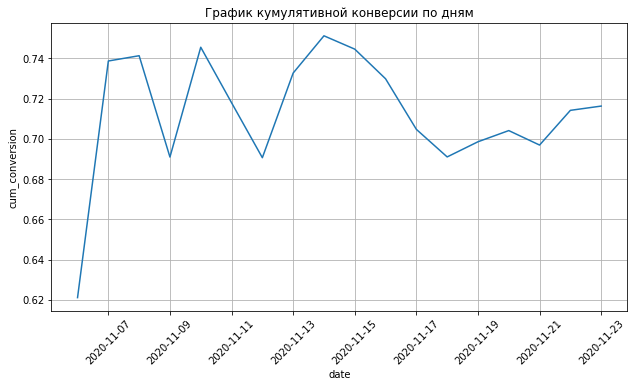

In [35]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_data_sample_a,  ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

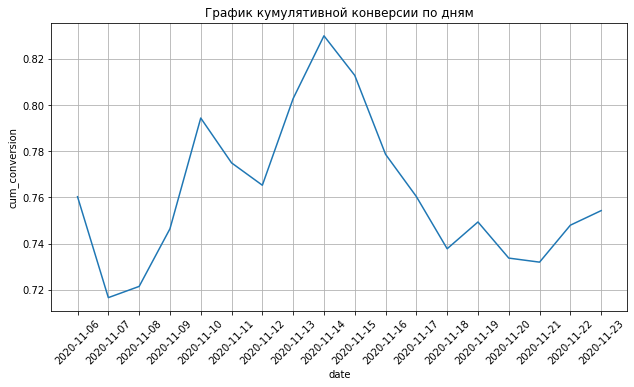

In [36]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_data_sample_b,  ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Начиная с 9 ноября 2020 года конверсии в группах имеют приблизительно идентичное поведение (одинаковые точки роста и спада). При этом конверсия в группе B стабильно выше конверсии в группе A на данном периоде. 

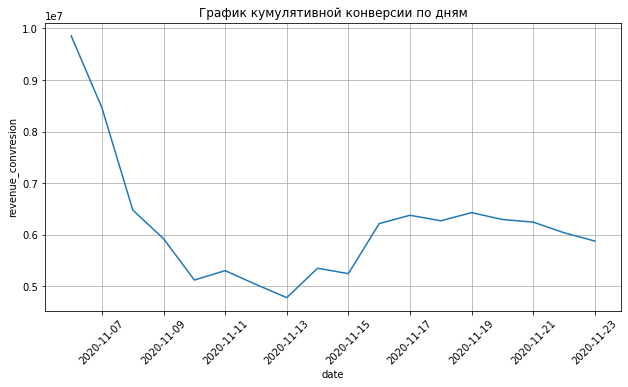

In [37]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='revenue_convresion', data=daily_data_sample_a,  ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

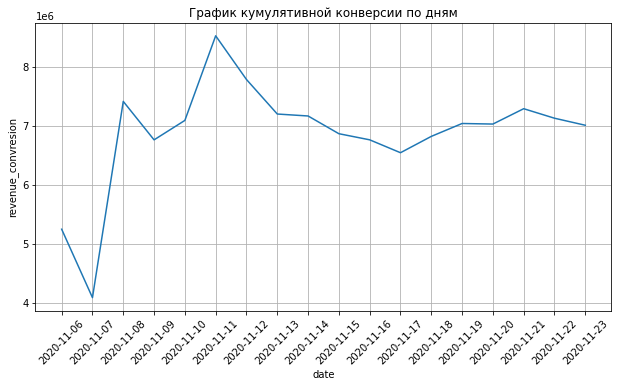

In [39]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='revenue_convresion', data=daily_data_sample_b,  ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

В начале периода наблюдения средний чек в группе B был меньше, чем средний чек в группе A. Однако при стабилизации метрик наблюдается обратный результат. 

### Анализ результатов A/B-тестирования: статистические тесты

В прошлом модуле мы рассматривали различные статистические тесты и их использование в Python. Суть статистических тестов заключается в том, чтобы удостовериться в справедливости некоторой гипотезы или опровергнуть её на основе предоставленных данных (выборки).

А мы как раз этим с вами и занимаемся! 

#### СТАТИСТИЧЕСКИЙ ТЕСТ ДЛЯ КОНВЕРСИИ

In [40]:
from statsmodels.stats.proportion import proportions_ztest

группируем данные по признаку группы и рассчитаем количество «успехов» (сумма по столбцу converted) и общее количество наблюдений (количество непустых значений в столбце converted) для каждой группы.

In [41]:
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17467,145241
B,17238,145241


Итак, будем проверять следующую новую гипотезу:
H0: pa = pb, то есть конверсии в группах А и B равны.

При правосторонней альтернативной гипотезе: H1: pa > pb,  то есть конверсия в группе А выше, чем конверсия в группе B.

Z-статистика нас пока что не интересует, а вот p-value занесём в отдельную переменную для дальнейшего сравнения с уровнем значимости.

In [42]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

p-value:  0.1
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Что это значит для нас и для бизнеса? Так как z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), то полученная разница в метрике в группах статистически не значима. Переводим на язык бизнеса: разницы между вариантами рекомендаций сопутствующих товаров нет — они одинаково эффективны по метрике конверсии! 

##### На основе этого вывода мы принимаем решение о том, что делать дальше. Возможные варианты:

отказаться от внедрения ML-модели для рекомендаций сопутствующих товаров и оставить использование текущей версии рекомендаций;

попытаться усовершенствовать модель и провести тестирование снова;

использовать оба варианта системы рекомендаций и посмотреть на результат в более долгосрочной перспективе.

### СТАТИСТИЧЕСКИЕ ТЕСТЫ ДЛЯ ДРУГИХ МЕТРИК

In [43]:
time_data = pd.read_excel('data/time_data.xlsx')
display(time_data.head())

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


#### Построим гистограмму времени, проведённом пользователями на сайте в каждой из групп:

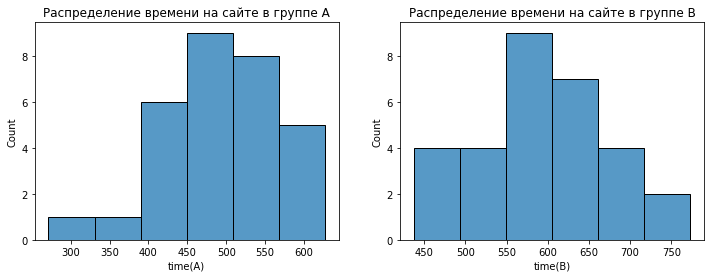

In [44]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

#### Гистограммы напоминают нормальное распределение. Давайте проверим гипотезу о нормальности обоих распределений с помощью критерия Шапиро-Уилка. Для этого используем функцию shapiro() из модуля scipy.stats:

In [45]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value группы А 0.43
# p-value группы B 0.12
# Принимаем нулевую гипотезу. Распределения в обеих группах нормальные

p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


Итак, распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом для того, чтобы сравнить среднее время посещения сайта в группах.

Выдвигаем нулевую гипотезу:

, то есть среднее время в группах А и B одинаково.
При левосторонней альтернативной гипотезе:

, то есть среднее время в группе А меньше, чем в группе B.

##### Применим T-тест для сравнения средних — функцию ttest_ind() из модуля scipy.stats. Обратите внимание, что левосторонняя альтернативная гипотеза в модуле scipy указывается в параметре alternative как 'less' (правосторонняя — 'greater’):

In [46]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value: 0.0
# Отвергаем нулевую гипотезу. Среднее время в группах одинаково
# Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B

p-value: 0.0
Отвергаем нулевую гипотезу. Среднее время в группах одинаково
Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B


#### Конверсия является долевым показателем. Для проверки гипотезы о равенстве долей (пропорций) используется Z-тест для пропорций.

In [47]:
from statsmodels.stats.proportion import proportions_ztest

Подсказка (1 из 1): В функцию необходимо передать три параметра:
count — список из общего числа транзакций в группах А и B (суммы по столбцам transactions).
nobs — число наблюдений в группах А и B (количество значений в столбце cid).
alternative — параметр устанавливаем в 'smaller'.

In [50]:
p_0 = 0.1
a_count = sample_b['transactions'].sum()+sample_a['transactions'].sum()
a_nobs =  sample_b['cid'].count()+sample_a['cid'].count()

#perform one proportion z-test
_, p = proportions_ztest(count=a_count, nobs=a_nobs, value = p_0, alternative='smaller' )
print(p)

0.0


Проверьте гипотезу о нормальности распределений ежедневного среднего чека с помощью критерия Шапиро-Уилка. В качестве уровня значимости возьмите 0.1.

In [51]:
from scipy.stats import shapiro

In [54]:
alpha = 0.1

#_, p = shapiro(sample_a)
#print('p=%.3f' % p)

#_, p = shapiro(sample_b)
#print('p=%.3f' % p)



Проверьте гипотезу о равенстве ежедневных средних чеков с помощью критерия Манна-Уитни при альтернативной гипотезе: Ежедневный средний чек в группе А меньше, чем в группе B. Используйте функцию mannwhitneyu() из модуля scipy.stats. В качестве уровня значимости возьмите .

In [55]:
from scipy.stats import mannwhitneyu

### Анализ результатов A/B-тестирования: доверительные интервалы

Итак, мы с вами знаем, что на основе выборки (части наблюдений) мы всегда можем измерить следующие показатели:

выборочное среднее (центральная мера распределения);
выборочное стандартное отклонение (мера разброса);
выборочную пропорцию (доля объектов из выборки, выбранных по условию, например доля пользователей, совершивших покупки).
Однако эти оценки не являются нашим основным предметом интереса. На самом деле нас интересуют параметры генеральной совокупности: 

истинное среднее — математическое ожидание ();
истинное стандартное отклонение ();
истинная пропорция ().

#### С точечными оценками на самом деле мы уже знакомы и не раз их вычисляли — это просто выборочные статистики. Например, мы собрали данные о росте прохожих людей и посчитали среднее, стандартное отклонение и так далее. Почему они точечные? Потому что они дают ответ точечно, то есть в виде одного числа.

Однако есть у такого подхода и существенный недостаток: полученное значение практически никогда не равно истинному. 

#### Интервальные оценки — это ещё один способ оценки параметров генеральной совокупности, при использовании которого ответ даётся не в виде одного числа, а в виде интервала. 

### Доверительный интервал — интервал, который с заданной надёжностью покрывает значение неизвестного параметра.

### ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ СРЕДНЕГО ПРИ ИЗВЕСТНОМ ИСТИННОМ СТАНДАРТНОМ ОТКЛОНЕНИИ

Вывод. Под уровнем надёжности понимается вероятность того, что истинное значение параметра окажется в построенном интервале. А под уровнем значимости — вероятность того, что построенный доверительный интервал «промахнётся» и не захватит истинное значение параметра.

Это константа, которая берётся из таблицы, и её значение мы задаём, когда указываем надёжность, с которой хотим построить интервал:

Была опрошена случайная выборка из 36 жителей региона об их затратах на продукты питания за последний месяц. Выборочное среднее оказалось равным 16 100 рублей.
Допустим, откуда-то известно, что истинное стандартное отклонение расходов равно 12 000 рублей.
Нам нужно построить доверительный интервал для истинных средних расходов жителя данного региона на продукты питания в месяц. Интервал должен определять истинное значение с надежностью в 95 %.

In [56]:
from scipy.stats import norm

n = 36 # размер выборки
x_mean = 16100 # выборочное среднее
sigma = 12000 # истинное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

z_crit = -norm.ppf(alpha/2) # z критическое

eps = z_crit * sigma/(n ** 0.5) #погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат
 
 
 
# Доверительный интервал: (12180, 20020)

Примечание. Заметьте, что это универсальный код. Если перед вами возникнет другая задача расчёта доверительного интервала для истинного среднего, то вам достаточно будет правильно поменять значения переменных. Вы можете оформить его в виде функции и сохранить её, чтобы не строить каждый раз новый доверительный интервал

Полученный результат интерпретируется следующим образом: мы на 95 % уверены, что истинные расходы жителей на продукты питания лежат в интервале от 12 180 рублей до 20 020 рублей. 

Важно! Доверительный интервал не даёт нам 100 % результата. Всегда есть шанс, что мы промахнулись и не захватили истинного значения. Этот шанс как раз равен уровню значимости .
То есть в нашем примере существует 5 %-ый шанс, что истинное среднее расходов вовсе не лежит в интервале от 12 180 до 20 020. Существует вероятность, что математическое ожидание на самом деле равно 5 000 рублей или 25 000 рублей. Но такая вероятность составляет менее 5 %, и это нас устраивает.

Что такое z-критическое? - значение, которое определяется уровнем надёжности (уровнем значимости) на основе нормального распределения 

Аккумуляторный завод производит батарейки, срок службы которых имеет истинное стандартное отклонение в 2.4 месяца. Средний срок службы батареек в случайной выборке из 64 штук составил 12.35 месяца. Необходимо построить 90 %-ный доверительный интервал для истинного среднего срока службы производимой батарейки и ответить на вопросы заданий ниже.

In [57]:
n = 64 # размер выборки
x_mean = 12.35 # выборочное среднее
sigma = 2.4 # истинное стандартное отклонение
gamma = 0.90 # уровень надежности
alpha = 1 - gamma # уровень значимости
z_crit = -norm.ppf(alpha/2) # z-критическое
print('z критическое: {}'.format(round(z_crit, 2)))
eps = z_crit * sigma/(n ** 0.5) #погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound, 2), round(upper_bound, 2)) # создаем кортеж из округленных границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

z критическое: 1.64
Доверительный интервал: (11.86, 12.84)


#### ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ СРЕДНЕГО ПРИ НЕИЗВЕСТНОМ СТАНДАРТНОМ ОТКЛОНЕНИИ

Управляющий супермаркета хочет оценить, сколько денег покупатели тратят за один поход в супермаркет в среднем. На основании ранее собранных данных известно, что расходы одного покупателя распределены приблизительно нормально. Управляющий взял случайную выборку из 15 покупателей и выяснил, что их средние расходы равны 2 000 рублей, а выборочное стандартное отклонение равно 400 рублей.

Для оценки управляющий хочет построить доверительный интервал с надёжностью в 95 %.

Давайте поможем управляющему, решив несколько задачек с помощью Python.

Итак, зададим необходимые для решения задачи переменные:

In [59]:
n = 15 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 2000 # выборочное среднее
x_std = 400 # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

Найти значение t-критического для любого уровня значимости можно, используя функцию t.ppf() из модуля scipy.stats. Для этого в функцию передаётся интересующий уровень значимости () и число степеней свободы (). Аналогично z-критическому функция возвращает отрицательный модуль t-критического, поэтому мы берём его со знаком минус:

In [60]:
from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

In [61]:
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат
 
 
# Доверительный интервал: (1778, 2222)

Доверительный интервал: (1778, 2222)


Чиновника интересует сумма подоходного налога, выплачиваемого домохозяйствами за год. На случайной выборке из 25 домохозяйств был посчитан средний размер выплаченного налога, и он составил $ 3 540. Также известно выборочное отклонение величины подоходного налога, равное $ 1 150.

In [63]:
n = 25 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 3540 # выборочное средней
x_std = 1150 # выборочное стандартное отклонение
gamma = 0.90 # уровень надежности
alpha = 1 - gamma # уровень значимости
t_crit = -t.ppf(alpha/2, k) # t критическое
print('t критическое: {}'.format(round(t_crit, 2)))
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound, 2), round(upper_bound, 2)) # создаем кортеж из округленных границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

t критическое: 1.71
Доверительный интервал: (3146.5, 3933.5)


### ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ ПРОПОРЦИИ

In [64]:
#фильтруем данные группы А
a_data = ab_data[ab_data['group'] == 'A']
#фильтруем данные группы B
b_data = ab_data[ab_data['group'] == 'B']

Давайте на этот раз оформим расчёт в виде функции: объявим функцию proportions_conf_interval(). У данной функции будет три аргумента: n — размер выборки, x_p — выборочная пропорция и gamma — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала, умноженных на 100 % и округлённых до второго знака после запятой.

In [65]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [66]:
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['converted'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['converted'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))
# Доверительный интервал для конверсии группы А: (11.86, 12.19)
# Доверительный интервал для конверсии группы B: (11.7, 12.03)

Доверительный интервал для конверсии группы А: (11.86, 12.19)
Доверительный интервал для конверсии группы B: (11.7, 12.03)


Создадим функцию diff_proportions_conf_interval() со следующими аргументами: n — список из размеров выборки для групп А и B соответственно, xp — список из выборочных пропорций для групп А и B соответственно и gamma — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала разницы конверсий, умноженных на 100 % и округлённых до второго знака после запятой.

In [67]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [68]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['converted'].mean(), b_data['converted'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))
 
# Доверительный интервал для разности конверсий: (-0.39, 0.08)

Доверительный интервал для разности конверсий: (-0.39, 0.08)


Итак, что можно сказать теперь? Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.39 % до 0.08 %. 

Выберите кейсы, для которых может быть использован доверительный интервал для пропорций.

Верно:

Вариант B верный. Вероятность того, что случайно выбранный студент имеет рост 189 сантиметров — это истинная пропорция студентов, имеющих рост 189. Для оценки этого параметра используется доверительный интервал для пропорций.

Вариант C верный. Признак регистрации на сайте — бинарная величина, которая имеет два исхода: посетитель зарегистрировался или нет. Истинная доля регистраций — это пропорция зарегистрированных пользователей. Для оценки этого параметра используется доверительный интервал для пропорций.

Было проведено А/B-тестирование главной страницы сайта. В контрольной версии сайта на главной странице использовалась фотография, а в тестовой версии — видео. Варианты сравниваются по доле зарегистрировавшихся пользователей. Расчёты на основе результатов тестирования, что доверительный интервал разницы долей зарегистрировавшихся на сайте пользователей (в процентах) между вариантами B и A с 95 % надёжностью имеет вид: . Какие выводы можно сделать из построенного интервала?



Разница в конверсии регистрации находится в интервале от 5.32 % до 8.51 %. Обе границы положительны, что говорит о том, что для повышения регистраций на сайте на главной странице следует использовать видео. 

Пояснение

Обе границы доверительного интервала для разницы пропорций являются положительными. Значит, разница конверсии регистрации (конверсия группы B - конверсия группы A) может быть только положительной. Отсюда вариант B (использование видео на стартовой странице) является более эффективным по метрике конверсии регистрации.

Чтобы оценить удовлетворённость клиентов сети отелей, менеджер взял случайную выборку из 189 комментариев, оставленных посетителями на онлайн-платформе по бронированию, и провёл анализ их содержания. Выяснилось, что 132 комментария были положительными, остальные — негативными.

In [69]:
def conversion_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)
n = 189 # размер выборки
n_positive = 132 # число положительных исходов
x_p = n_positive/n # выборочная пропорция
print('Выборочная пропорция: {}'.format(round(x_p, 3)))
 
print('Доверительный интервал: {}'.format(conversion_conf_interval(n, x_p, gamma=0.9)))

Выборочная пропорция: 0.698
Доверительный интервал: (64.35, 75.33)


Подсказка (1 из 2):
Выборочная пропорция положительных комментариев — это число положительных комментариев, поделённое на число всех комментариев.

Подсказка (2 из 2):
После того как вы нашли выборочную пропорцию x_p, вам останется только подставить размер выборки n и полученную x_p в функцию proportions_conf_interval(), которую мы создали ранее. Не забудьте указать параметр gamma=0.9.

Проводится A/B-тестирование вариантов отображения страницы корзины на сайте интернет-магазина. Есть два варианта отображения страницы: с товарными рекомендациями «Хиты продаж» и персональными, подобранными под интерес конкретно этого пользователя. Метрикой является конверсия действия «добавить в корзину товар из рекомендаций». Были собраны следующие данные:

Группа

Число добавленных в корзину товаров

Размер выборки

А (Персональные скидки)

45

1000

B (Хиты продаж)

50

1000

Постройте 95 %-ый доверительный интервал разности полученных конверсий. Ответ приведите в процентах и округлите границы интервала до второго знака после запятой. При расчёте используйте z-критическое.

In [70]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)
 
n = 1000 # размер выборки обеих групп
n_positive_a = 45 # число конвертировавших в группе А
n_positive_b = 50 # число конвертировавших в группе B
xp_a = n_positive_a/n # выборочная пропорция группы A
xp_b = n_positive_b/n # выборочня пропорция группы B
confidence_interval = diff_proportions_conf_interval(
    n=[n, n],
    xp=[xp_a, xp_b]
)
print('Доверительный интервал: {}'.format(confidence_interval))

Доверительный интервал: (-1.36, 2.36)
